# Practical Lab 7 - Performance Metrics for Classification

## Introduction

The goal is to develop a model to recognize/classify digits of MNIST dataset. We are going to use MNIST dataset which consists of 70,000 images of numbers from 0 t0 9. The images are represented as pixels. There are around 784 features representing the pixel values. Each image corresponds to a pixel array of 28X28. 

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

In [32]:
# Fetching the MNIST dataset from openml
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')

In [34]:
# Converting it to a dataframe
df_mnist_dataset = mnist.data


(70000, 784)


In [35]:
# Appending the Target column to the input features
df_mnist_dataset['Target'] = mnist.target

In [36]:
# Displaying the top 5 rows of the dataframe
df_mnist_dataset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Data Exploration

Inspiration for Exploratory data analysis on image dataset is taken from kaggle. Here is the link to the Kaggle Notebook [Exploratory Data Analysis (EDA) for Image Datasets](https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets)

In [42]:
pixels = np.array(df_mnist_dataset.iloc[:,0:784])
label = df_mnist_dataset['Target']

### Displaying the first 100 images and corresponding labels

In [47]:
def plot_digit(image_data,label):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.title(f"Digit: {label}", fontsize=8)
    plt.axis("off")

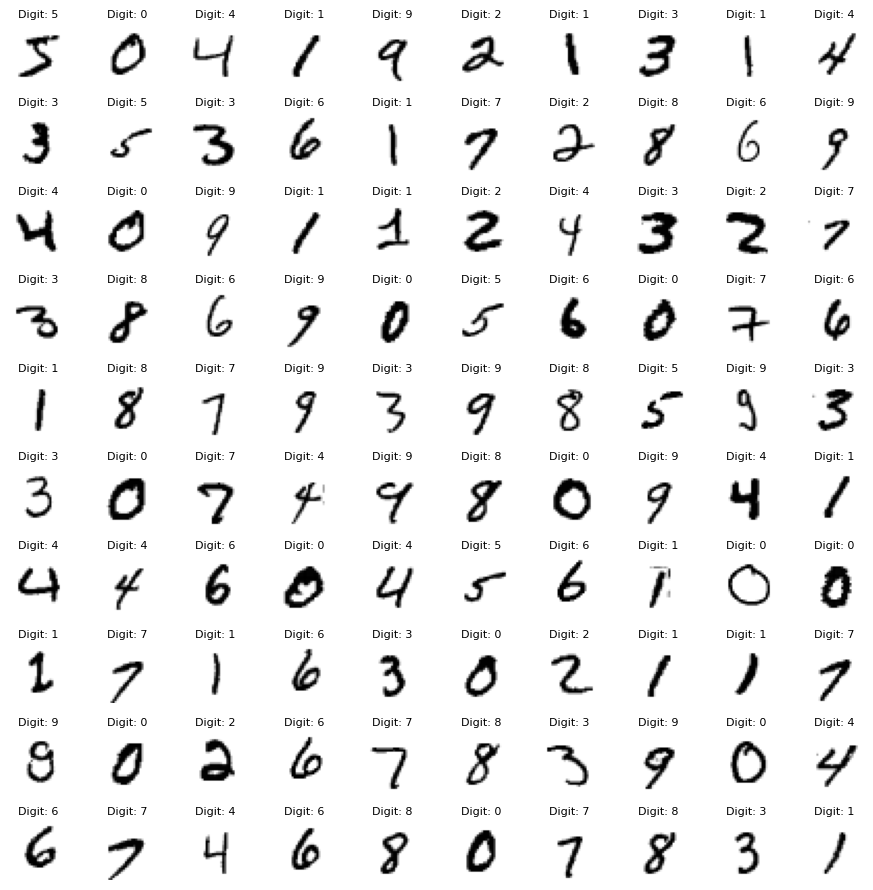

In [49]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(pixels[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data,label[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

### Count Plot

The number of images count in each class is displayed using a count plot. From the count plot, it is clear that each class has **unequal number of images**. The **digit 1** has **maximum number of images - 7877** and **digit 5** has the **least number of images - 6313**

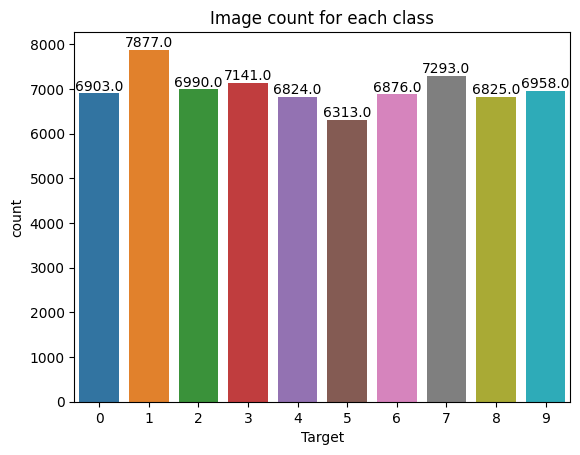

In [50]:
sns.countplot(df_mnist_dataset,x = "Target")
plt.title('Image count for each class')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Pie Chart

The pie chart % of images in class in descending order. From the chart, we can find that the **digit class** 1 has the **highest percentage** of data **11.3%** followed by digit class 7 and digit class 3. **Digit 5** has the **least percentage of 9.02%**. The dataset is **balanced**

In [54]:
# Calculate the target distribution
Target_Dist_Total = df_mnist_dataset['Target'].value_counts(sort=False)

# Create a pie chart
fig = px.pie(Target_Dist_Total, values=Target_Dist_Total, names=Target_Dist_Total.index, hole=0.5)

# Update layout
fig.update_layout(
    title='Data Distribution of MNIST Dataset',
    font_size=15,
    title_x=0.45,
    annotations=[dict(text='MNIST Dataset', font_size=12, showarrow=False, x=0.5, y=0.5)]
)

# Update traces
fig.update_traces(textfont_size=15, textinfo='percent')

fig.show()

## Data Pre-Processing

In [85]:
# Filtering the dataset containing only classes of digits 4,6 and 8
df_three_classes = df_mnist_dataset[df_mnist_dataset['Target'].isin(['4','6','8'])].reset_index()

In [86]:
# Printing the shape of the data frame
display(df_three_classes)

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Target
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20520,69987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
20521,69989,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
20522,69991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
20523,69997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [87]:
# Checking the uniques values of Target
df_three_classes['Target'].unique()

['4', '6', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [88]:
# splitting it into input features and target variable
X = np.array(df_three_classes.iloc[:,0:784])
y = df_three_classes['Target']

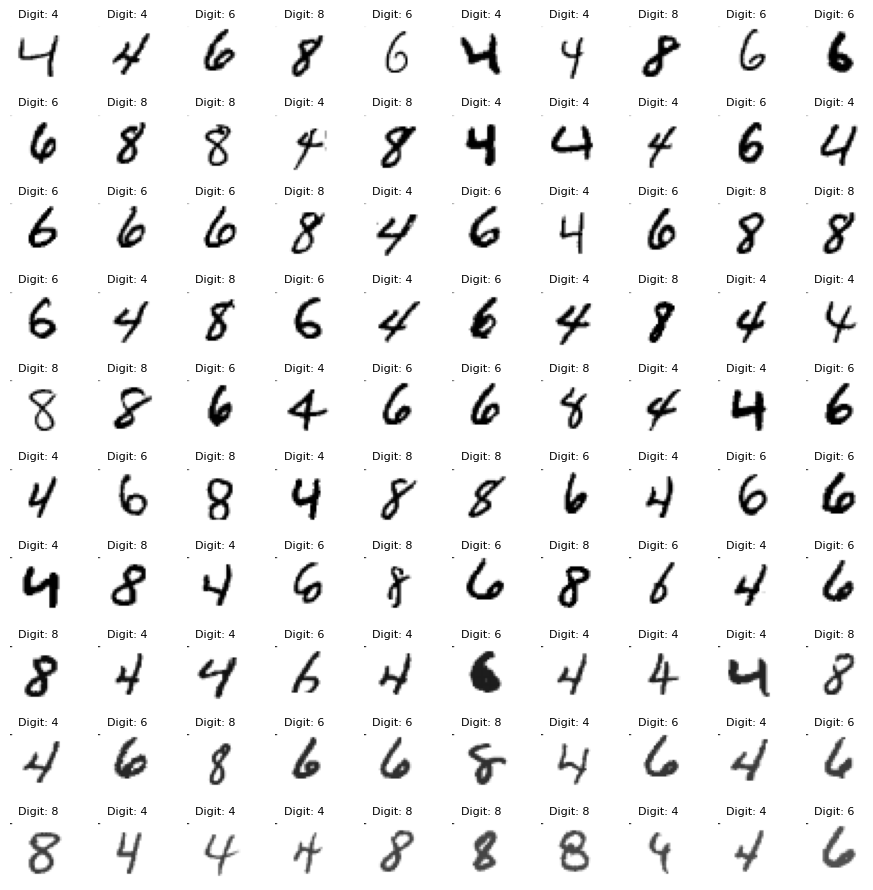

In [91]:
# Validating the first 100 images of filtered dataframe whether it contains only digits 4,6 and 8
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data,y[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

In [93]:
# Split the data into train and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

## Modeling

In [97]:
# Defining the SGDClassifier model
sgd_clf = SGDClassifier(random_state=42)
# Training the SGDClassifier with training dataset
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [128]:
# Model prediction on the validation set
y_val_pred = sgd_clf.predict(X_val)

In [129]:
# Confusion matrix
cm = confusion_matrix(y_val,y_val_pred)
print(cm)

[[ 889   63   13]
 [   1 1049    5]
 [   6   35 1018]]


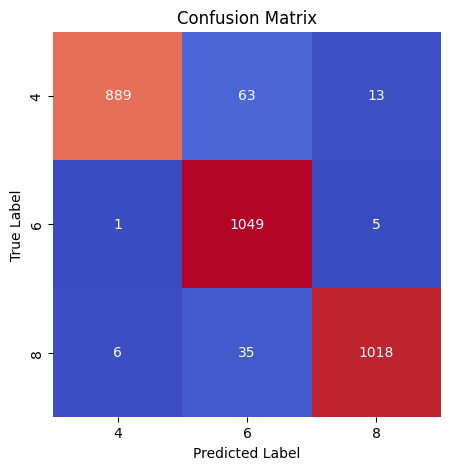

In [130]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [152]:
precision,recall,f1score,_ = precision_recall_fscore_support(y_val,y_val_pred, average=None,labels=y.unique())

In [153]:
val_results = []

In [154]:
for index,label in enumerate(y.unique()):
    val_results.append([label,precision[index],recall[index],f1score[index]])


In [155]:
df_val_results = pd.DataFrame(val_results,columns=['Class','Precision','Recall','F1 Score'])
display(df_val_results)

,Class,Precision,Recall,F1 Score
0,4,0.992188,0.921244,0.955400
1,6,0.914560,0.994313,0.952770
2,8,0.982625,0.961284,0.971838


In [156]:
# calculating the Overall accuracy, precision, recall and F1 score on validation set
overall_metric = [["SGD Classifier",accuracy_score(y_val,y_val_pred),precision_score(y_val,y_val_pred,average='weighted'),recall_score(y_val,y_val_pred,average='weighted'),f1_score(y_val,y_val_pred,average='weighted')]]

In [157]:
df_overall_val_results = pd.DataFrame(overall_metric,columns=['Model','Accuracy','Precision','Recall','F1 Score'])
display(df_overall_val_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,SGD Classifier,0.960052,0.9623,0.960052,0.960153
